# _*Option Pricing with qGANs*_ 


## Introduction
In this notebook, we discuss how a Quantum Machine Learning Algorithm, namely a quantum Generative Adversarial Network (qGAN), can facilitate the pricing of a European call option. More specifically, a qGAN can be trained such that a quantum circuit models the spot price of an asset underlying a European call option. The resulting model can then be integrated into a Quantum Amplitude Estimation based algorithm to evaluate the expected payoff - see [European Call Option Pricing](03_european_call_option_pricing.ipynb). <br/>
For further details on learning and loading random distributions by training a qGAN please refer to <a href="https://www.nature.com/articles/s41534-019-0223-2">Quantum Generative Adversarial Networks for Learning and Loading Random Distributions. Zoufal, Lucchi, Woerner. 2019.</a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import Aer, QuantumRegister, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal, NormalDistribution
from qiskit.quantum_info import Statevector

from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_finance.applications.estimation import EuropeanCallPricing

### Uncertainty Model

The Black-Scholes model assumes that the spot price at maturity $S_T$ for a European call option is log-normally distributed. Thus, we can train a qGAN on samples from a log-normal distribution and use the result as an uncertainty model underlying the option.
<br/>
In the following, we construct a quantum circuit that loads the uncertainty model. The circuit output reads 

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1}\sqrt{p_{\theta}^{j}} \big| j \rangle , $$

where the probabilities $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, represent a model of the target distribution.

In [2]:
# Set upper and lower data values
bounds = np.array([0.,7.])
# Set number of qubits used in the uncertainty model
num_qubits = 3

# Load the trained circuit parameters
g_params = [0.29399714, 0.38853322, 0.9557694, 0.07245791, 6.02626428, 0.13537225]

# Set an initial state for the generator circuit
init_dist = NormalDistribution(num_qubits, mu=1., sigma=1., bounds=bounds)

# construct the variational form
var_form = TwoLocal(num_qubits, 'ry', 'cz', entanglement='circular', reps=1)

# keep a list of the parameters so we can associate them to the list of numerical values
# (otherwise we need a dictionary)
theta = var_form.ordered_parameters  

# compose the generator circuit, this is the circuit loading the uncertainty model
g_circuit = init_dist.compose(var_form)

### Evaluate Expected Payoff
Now, the trained uncertainty model can be used to evaluate the expectation value of the option's payoff function with Quantum Amplitude Estimation.

In [3]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

# set the approximation scaling for the payoff function
c_approx = 0.25

# construct circuit for payoff function
european_call_pricing = EuropeanCallPricing(num_qubits, strike_price=strike_price, rescaling_factor=c_approx,
                                            bounds=bounds, uncertainty_model=uncertainty_model)

NameError: name 'uncertainty_model' is not defined

### Plot the probability distribution
Next, we plot the trained probability distribution and, for reasons of comparison, also the target probability distribution.

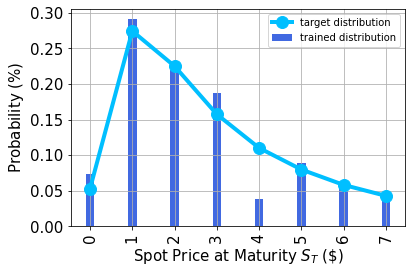

In [14]:
# Evaluate trained probability distribution
values = [bounds[0] + (bounds[1] - bounds[0]) * x / (2 ** num_qubits - 1) for x in range(2**num_qubits)]
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data

x = np.array(values)
y = np.abs(amplitudes) ** 2

# Sample from target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=1, sigma=1, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 7]
log_normal_samples = []
for i in range(8):
    log_normal_samples += [np.sum(log_normal==i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

# Plot distributions
plt.bar(x, y, width=0.2, label='trained distribution', color='royalblue')
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.plot(log_normal_samples,'-o', color ='deepskyblue', label='target distribution', linewidth=4, markersize=12)
plt.legend(loc='best')
plt.show()

### Evaluate Expected Payoff
Now, the trained uncertainty model can be used to evaluate the expectation value of the option's payoff function analytically and with Quantum Amplitude Estimation.

Analytically calculated expected payoff w.r.t. the target distribution:  1.0615
Analytically calculated expected payoff w.r.t. the trained distribution: 0.9805


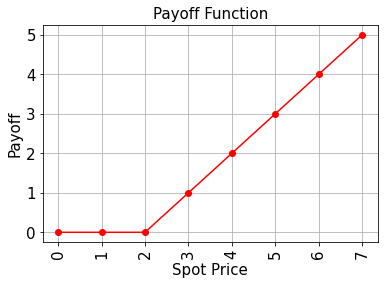

In [15]:
# Evaluate payoff for different distributions
payoff = np.array([0,0,0,1,2,3,4,5])
ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution:  %.4f" % ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: %.4f" % ep_trained)

# Plot exact payoff function (evaluated on the grid of the trained uncertainty model) 
x = np.array(values)
y_strike = np.maximum(0, x - strike_price)
plt.plot(x, y_strike, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [16]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=100)
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation 
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [17]:
result = ae.estimate(problem)

In [20]:
conf_int = np.array(result.confidence_interval_processed)
print('Exact value:        \t%.4f' % ep_trained)
print('Estimated value:    \t%.4f' % (result.estimation_processed))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

Exact value:        	0.9805
Estimated value:    	1.0353
Confidence interval:	[0.9209, 1.1497]


In [9]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright